# Knowledgegraph Preperation

Sample: https://www.motor-talk.de/forum/start-probleme-audi-a6-c4-2-6-abc-t6820263.html?page=1

In [1]:
import pandas as pd
from tqdm import tqdm

from parts import collect, cleaning, oie, domain_relevance

## Collecting
either from stored txt files or topic link in motor forum

In [2]:
# load post files
def load_files(limit):
    counter = 0
    path = "resources/txt/car/"
    corpus = []
    while counter < limit:
        try:
            with open(path + "/" + str(counter) + ".txt", "r") as file:
                corpus.append(file.read())
            counter += 1
        except UnboundLocalError:
            print("unicode error")
            counter += 1
    return corpus

In [4]:
corpus = load_files(1000)

## OIE
extract terms and root words from each sentence

In [5]:
# precleaning -> delete questions, short sentences
corpus_no_questions = []
for doc in tqdm(corpus):
    clean_doc = cleaning.sentences(doc, 1)
    corpus_no_questions.append(clean_doc)

100%|██████████| 1000/1000 [31:25<00:00,  1.89s/it] 


In [6]:
roots, terms = [],[]

for post in tqdm(corpus_no_questions):
    post_roots, post_terms = oie.get_oie(post)
    roots.extend(post_roots)
    terms.extend(post_terms)

100%|██████████| 1000/1000 [02:45<00:00,  6.05it/s]


In [7]:
backup_roots = roots
backup_terms = terms

In [8]:
# post cleaning of terms
clean_terms = cleaning.terms(terms)

deleted time references: 0
deleted date references: 217
deleted links: 623
deleted quotes: 0
deleted ireg expressions: 0
deleted abbreviations: 1378


## Domain Relevancy
narrow down terms to domain relevant terms

In [38]:
# load concept list from domain relevancy file
with open("concepts.txt", "r") as f:
    content = f.readlines()
concepts = [x.strip() for x in content] 

In [39]:
# load list of german stopwords 
with open("resources/stopwords_ger.txt", "r") as f:
    content = f.readlines()
stop_words = [x.strip() for x in content] 

In [40]:
# get concepts from list and ignoring stopwords
domain_concepts = []  
for sent in clean_terms:
    t = set()
    for term in sent:
        if term in concepts and term not in stop_words:
            t.add(term)
    domain_concepts.append(t)

In [41]:
# dataframe visualisation
terms2 = []
for sent in domain_concepts:
    terms2.append(", ".join(sent))

df = pd.DataFrame(roots, columns=["roots"])
df["terms"] = pd.DataFrame(terms2)

df.head()

,roots,terms
0,verlieren,"kühlwasser, audi 80 b4, b4, audi"
1,stehen,kühl
2,verschluss,kühl
3,danke,hilfe
4,würd,kühlkreislauf


In [42]:
#delete empty sets
roots_2 = []
terms_2 = []
for root, sent in zip(roots, domain_concepts):
    if sent:
        roots_2.append(root)
        terms_2.append(sent)
roots = roots_2
terms = terms_2

# Association Rule Mining

## Search all relations for most common words

In [ ]:
def get_term_relations(terms, roots, window_size=1):
    cooccurrence = dict()
    indicies = set()
    
    for root, sent in zip(roots, terms):
        for term_x in sent:
            for term_y in sent:
                index = term_x + "," + term_y
                reverse_index = term_y + "," + term_x
                if term_x == term_y:
                    pass
                elif reverse_index in indicies:
                    pass
                elif index not in indicies and reverse_index not in indicies:
                    indicies.add(index)
                    cooccurrence[index] = [root]
                else:
                    cooccurrence[index].append(root)
    return cooccurrence

In [ ]:
cooccurrence = get_term_relations(terms, roots)

In [11]:
# get most common relation#
from collections import Counter

relations = {}

for index in cooccurrence:
    relations[index] = Counter(cooccurrence[index]).most_common(1)[0][0]

NameError: name 'cooccurrence' is not defined

In [ ]:
flat_terms = [item for sublist in domain_concepts for item in sublist]
df = pd.Series(Counter(flat_terms))

In [ ]:
df.sort_values(ascending= False).head(10)

In [ ]:
most_common_terms = Counter(flat_terms).most_common(10)

In [ ]:
common_term_x = []
common_term_y = []
common_relation = []

for a in most_common_terms:
    for b in most_common_terms:
        index = a[0] + "," + b[0]
        reverse_index = b[0] + "," + a[0]
        if index in relations:
            common_term_x.append(a[0])
            common_term_y.append(b[0])
            common_relation.append(relations[index])
        elif reverse_index in relations:
            common_term_x.append(a[0])
            common_term_y.append(b[0])
            common_relation.append(relations[reverse_index])
        else: 
            pass

## Search most common relation for seed words

In [9]:
seed_word = "auto"
window_size = 2

window_terms = []
window_roots = []
seed_relations = []

for root, sent in zip(roots, terms):
    window_terms.append(sent)
    window_roots.append(root)
    flat_terms = [item for sublist in window_terms for item in sublist]
    if seed_word in flat_terms:
        for window_root, window_sent in zip(window_roots, window_terms):
            for window_term in window_sent:
                if window_term == seed_word or window_term == window_root:
                    pass
                else:
                    relation = window_root + "," + window_term
                    seed_relations.append(relation)
    if len(window_roots) > window_size:
        window_terms.pop(0)
        window_roots.pop(0)

In [12]:
Counter(seed_relations).most_common(10)

[('schreiben,original', 33),
 ('können,jahre', 23),
 ('alt,jahre', 22),
 ('haben,audi', 20),
 ('fahren,audi', 19),
 ('haben,km', 19),
 ('auto,super', 18),
 ('auto,jahre', 18),
 ('kaufen,audi', 18),
 ('stehen,jahre', 15)]

In [103]:
def get_seed_relation(terms, roots, seed_word, window_size = 1, limit = 3):
    window_terms = []
    window_roots = []
    seed_relations = []

    for root, sent in zip(roots, terms):
        window_terms.append(sent)
        window_roots.append(root)
        flat_terms = [item for sublist in window_terms for item in sublist]
        if seed_word in flat_terms:
            for window_root, window_sent in zip(window_roots, window_terms):
                for window_term in window_sent:
                    if window_term == seed_word or window_term == window_root:
                        pass
                    else:
                        relation = window_root + "," + window_term
                        seed_relations.append(relation)
        if len(window_roots) > window_size:
            window_terms.pop(0)
            window_roots.pop(0)
    
    return Counter(seed_relations).most_common(limit)

In [43]:
flat_terms = [item for sublist in domain_concepts for item in sublist]

In [107]:
most_common_terms = Counter(flat_terms).most_common(100)

In [108]:
get_seed_relation(terms, roots, "auto", 5, 5)

[('schreiben,original', 294),
 ('haben,km', 101),
 ('haben,audi', 87),
 ('fahren,audi', 86),
 ('habe,audi', 73)]

In [109]:
seed_term_x = []
seed_term_y = []
seed_relation = []

for term in most_common_terms:
    seed_relations = get_seed_relation(terms, roots, term[0], 3, 5)
    for relation in seed_relations:
        if relation[1] > 3:
            relation_root, relation_term_y = relation[0].split(",")
            if relation_root != "schreiben":
                seed_term_x.append(term[0])
                seed_term_y.append(relation_term_y)
                seed_relation.append(relation_root)
        else:
            print("min relation number not reached")

# Visualisation

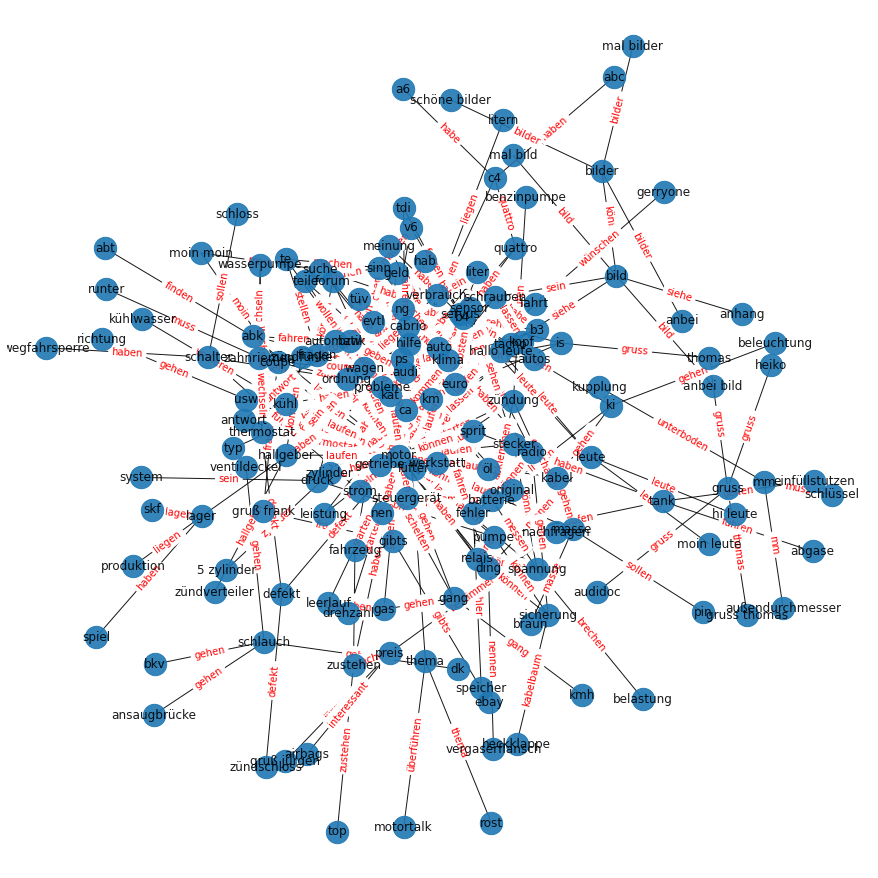

In [110]:
import networkx as nx 
import matplotlib.pyplot as plt 
%matplotlib inline

G = nx.Graph()
nodeA = seed_term_x
nodeB = seed_term_y
relation = seed_relation

for a, b in zip(nodeA, nodeB):
    G.add_edge(a, b)

pos = nx.spring_layout(G, k=0.15, iterations=20)
plt.figure(figsize=(12,12))
nx.draw(G,pos,width=1,linewidths=1,node_size=500,alpha=0.9,labels={node:node for node in G.nodes()})
labels = dict(zip(list(zip(nodeA, nodeB)),relation))
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_color='red')

plt.axis('off')
plt.show()

## Export

In [113]:
df = pd.DataFrame(nodeA, columns=["Node A"])
df["Node B"] = pd.DataFrame(nodeB)
df["Root"] = pd.DataFrame(relation)

In [115]:
df.head(20)

,Node A,Node B,Root
0,motor,audi,habe
1,motor,gas,geben
2,motor,km,haben
3,motor,probleme,haben
4,audi,b4,habe
5,audi,hallo leute,leute
6,audi,km,haben
7,audi,sinn,machen
8,auto,km,haben
9,auto,audi,fahren
